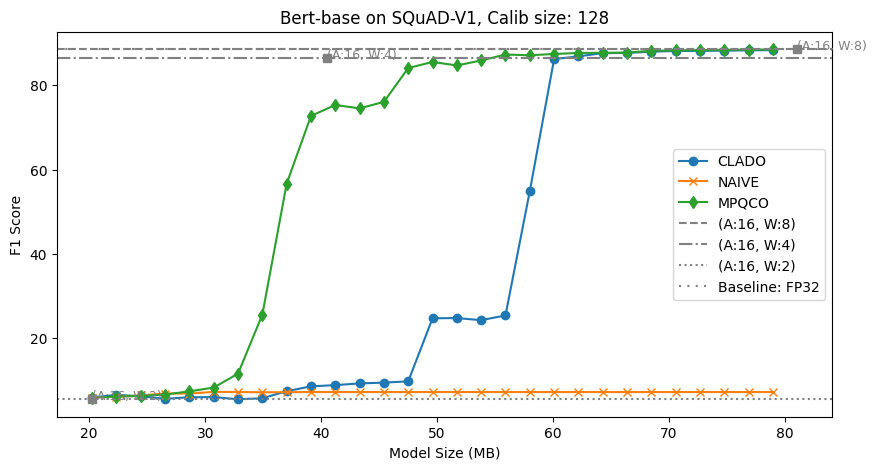

In [14]:
import matplotlib.pyplot as plt
import pickle
import numpy as np

methods = ["clado", "naive", "mpqco"]
size_bounds = np.linspace(20.2505, 81.05, 30)

n_runs = 5
n_constraints = len(size_bounds)

# n_runs x n_constraints 
clado_f1 = [[0 for _ in range(n_constraints)] for _ in range(n_runs)]
naive_f1 = [[0 for _ in range(n_constraints)] for _ in range(n_runs)]
mpqco_f1 = [[0 for _ in range(n_constraints)] for _ in range(n_runs)] 
clado_exact_match = [[0 for _ in range(n_constraints)] for _ in range(n_runs)]
naive_exact_match = [[0 for _ in range(n_constraints)] for _ in range(n_runs)]
mpqco_exact_match = [[0 for _ in range(n_constraints)] for _ in range(n_runs)]
clado_eval_loss = [[0 for _ in range(n_constraints)] for _ in range(n_runs)]
naive_eval_loss = [[0 for _ in range(n_constraints)] for _ in range(n_runs)]
mpqco_eval_loss = [[0 for _ in range(n_constraints)] for _ in range(n_runs)]

batch_num = 128
for repeat in range(n_runs):
    start_batch = batch_num * repeat
    end_batch = batch_num * repeat + batch_num - 1
    n_samples = batch_num * 8
    file_name = f'./clado_mpqco_results/bert-base/Clado_Naive_MPQCO_res_bert-base/sample_size{n_samples}/clado_naive_mpqco_a16_w8-4-2_calib128_batches_{start_batch}-{end_batch}_bs8.pkl'
    with open(file_name,'rb') as f:
        res = pickle.load(f)  
    for method in methods:
        j = 0  
        for item in eval(f'res["{method}_res"]'):
            eval_f1, eval_exact_match, eval_loss, size, bitops, _ = item
            cmd = f'{method}_f1[repeat][j] = {eval_f1}'
            exec(cmd)
            cmd = f'{method}_exact_match[repeat][j] = {eval_exact_match}'
            exec(cmd)
            cmd = f'{method}_eval_loss[repeat][j] = {eval_loss}'
            exec(cmd)
            j += 1

f1_clado = np.array(clado_f1)
f1_naive = np.array(naive_f1)
f1_mpqco = np.array(mpqco_f1)


xs = size_bounds[0:-1]
y_clado =  np.mean(f1_clado, axis=0)
y_naive =  np.mean(f1_naive, axis=0)
y_mpqco =  np.mean(f1_mpqco, axis=0)

plt.rcParams['figure.figsize'] = (10,5)

plt.plot(xs, y_clado[0:-1], marker='o', label=f'CLADO')
plt.plot(xs, y_naive[0:-1], marker='x', label=f'NAIVE')
plt.plot(xs, y_mpqco[0:-1], marker='d', label=f'MPQCO')

plt.plot([81.0],[88.51880994118912], color='gray', marker='s')
plt.annotate("(A:16, W:8)", (81, 88.51880994118912), size=9, color='gray')
plt.axhline(y=88.51880994118912, color='gray', linestyle='--', label='(A:16, W:8)')

plt.plot([40.5],[86.40668729458235], color='gray', marker='s')
plt.annotate("(A:16, W:4)", (40.5, 86.40668729458235), size=9, color='gray')
plt.axhline(y=86.40668729458235, color='gray', linestyle='-.', label='(A:16, W:4)')

plt.plot([20.25],[5.660030357217913,], color='gray', marker='s')
plt.annotate("(A:16, W:2)", (20.25, 5.660030357217913,), size=9, color='gray')
plt.axhline(y=5.660030357217913, color='gray', linestyle=':', label='(A:16, W:2)')

plt.axhline(y=88.51770447799038, color='gray', linestyle=(0, (1, 3)), label='Baseline: FP32')

plt.title('Bert-base on SQuAD-V1, Calib size: 128')
plt.ylabel('F1 Score')
plt.xlabel('Model Size (MB)')
plt.legend()
plt.show()


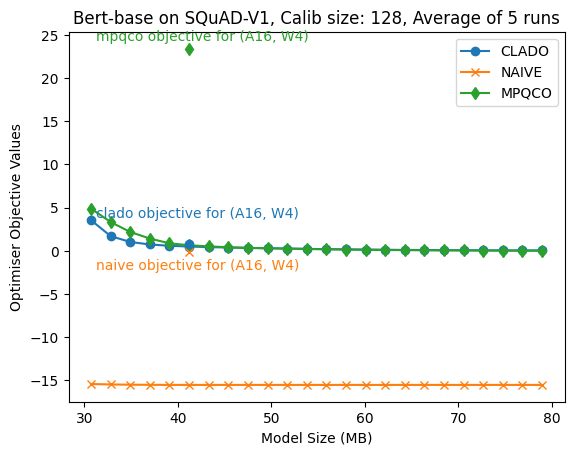

In [23]:

import matplotlib.pyplot as plt
import pickle
import numpy as np

methods = ["clado", "naive", "mpqco"]
size_bounds = np.linspace(20.2505, 81.05, 30)

n_runs = 5
n_constraints = len(size_bounds)

# n_runs x n_batches x n_constraints 
clado_objective = [[0 for _ in range(n_constraints)] for _ in range(n_runs)]
naive_objective = [[0 for _ in range(n_constraints)] for _ in range(n_runs)]
mpqco_objective = [[0 for _ in range(n_constraints)] for _ in range(n_runs)] 

batch_num = 128
for repeat in range(n_runs):
    start_batch = batch_num * repeat
    end_batch = batch_num * repeat + batch_num - 1
    n_samples = batch_num * 8
    file_name = f'./clado_mpqco_results/bert-base/Clado_Naive_MPQCO_optimization-objective_bert-base/sample_size{n_samples}/clado_naive_mpqco_a16_w8-4-2_calib128_batches_{start_batch}-{end_batch}_bs8.pkl'
    with open(file_name,'rb') as f:
        res = pickle.load(f)  
    for method in methods:
        j = 0  
        for item in eval(f'res["{method}_objectives"]'):
            cmd = f'{method}_objective[repeat][j] = {item}'
            exec(cmd)
            j += 1

clado_obj = np.array(clado_objective)
naive_obj = np.array(naive_objective)
mpqco_obj = np.array(mpqco_objective)

xs = size_bounds[5:-1]
y_clado =  np.mean(clado_obj, axis=0)
y_naive =  np.mean(naive_obj, axis=0)
y_mpqco =  np.mean(mpqco_obj, axis=0)

clado_all4b_objective = np.mean([0.7947470433804347, 0.7955339349661347, 0.8419105234334705, 0.7986986430964358, 0.7235177842198061])
naive_all4b_objective = np.mean([-0.10968611488351598, -0.16394045145716518, -0.21000938001088798, -0.15883338887942955, -0.23831430834252387])
mpqco_all4b_objective = np.mean([81.69815994184714, 2.0476717502207546, 27.825005696652624, 2.6393134322942187, 2.743853276654849])

plt.plot(xs, y_clado[5:-1], marker='o', label=f'CLADO')
plt.plot(xs, y_naive[5:-1], marker='x', label=f'NAIVE')
plt.plot(xs, y_mpqco[5:-1], marker='d', label=f'MPQCO')
plt.plot([41.2158448275862],[clado_all4b_objective], color=u'#1f77b4', marker='o')
plt.plot([41.2158448275862],[naive_all4b_objective], color=u'#ff7f0e', marker='x')
plt.plot([41.2158448275862],[mpqco_all4b_objective], color=u'#2ca02c', marker='d')
plt.annotate("clado objective for (A16, W4)", (41.2158448275862-10, clado_all4b_objective+3), size=10, color=u'#1f77b4')
plt.annotate("naive objective for (A16, W4)", (41.2158448275862-10, naive_all4b_objective-2), size=10, color=u'#ff7f0e')
plt.annotate("mpqco objective for (A16, W4)", (41.2158448275862-10, mpqco_all4b_objective+1), size=10, color=u'#2ca02c')

plt.title(f'Bert-base on SQuAD-V1, Calib size: 128, Average of 5 runs')
plt.ylabel('Optimiser Objective Values')
plt.xlabel('Model Size (MB)')
plt.legend()
plt.show()

# xs = size_bounds[0:-1]
# y_clado = clado_obj
# y_naive = naive_obj
# y_mpqco = mpqco_obj
# clado_all4b_objective = [0.7947470433804347, 0.7955339349661347, 0.8419105234334705, 0.7986986430964358, 0.7235177842198061]
# naive_all4b_objective = [-0.10968611488351598, -0.16394045145716518, -0.21000938001088798, -0.15883338887942955, -0.23831430834252387]
# mpqco_all4b_objective = [81.69815994184714, 2.0476717502207546, 27.825005696652624, 2.6393134322942187, 2.743853276654849]
# for i in range(0, 5, 1):
#     print(y_clado[i][10])
#     plt.plot(xs, y_clado[i][0:-1], marker='o', label=f'CLADO')
#     plt.plot(xs, y_naive[i][0:-1], marker='x', label=f'NAIVE')
#     plt.plot(xs, y_mpqco[i][0:-1], marker='d', label=f'MPQCO')
#     plt.plot([41.2158448275862],[clado_all4b_objective[i]], color=u'#1f77b4', marker='o')
#     plt.plot([41.2158448275862],[naive_all4b_objective[i]], color=u'#ff7f0e', marker='x')
#     plt.plot([41.2158448275862],[mpqco_all4b_objective[i]], color=u'#2ca02c', marker='d')
#     plt.annotate("clado objective for (A16, W4)", (41.2158448275862-10, clado_all4b_objective[i]+3), size=9, color=u'#1f77b4')
#     plt.annotate("naive objective for (A16, W4)", (41.2158448275862-10, naive_all4b_objective[i]-5), size=9, color=u'#ff7f0e')
#     plt.annotate("mpqco objective for (A16, W4)", (41.2158448275862-10, mpqco_all4b_objective[i]+3), size=9, color=u'#2ca02c')
    
#     plt.title(f'Bert-base on SQuAD-V1, Calib size: 128, run: {i}')
#     plt.ylabel('Optimiser Objective Values')
#     plt.xlabel('Model Size (MB)')
#     plt.legend()
#     plt.show()




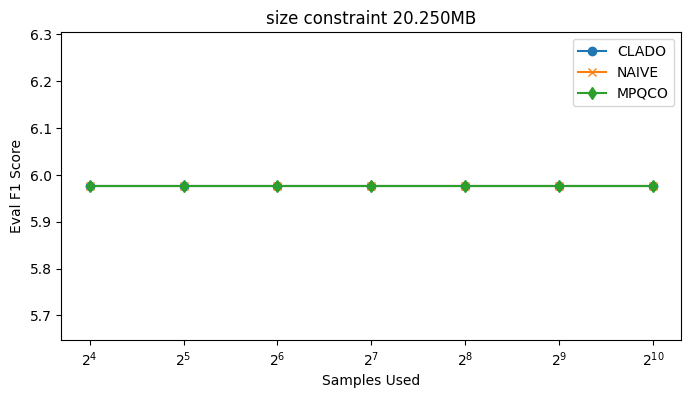

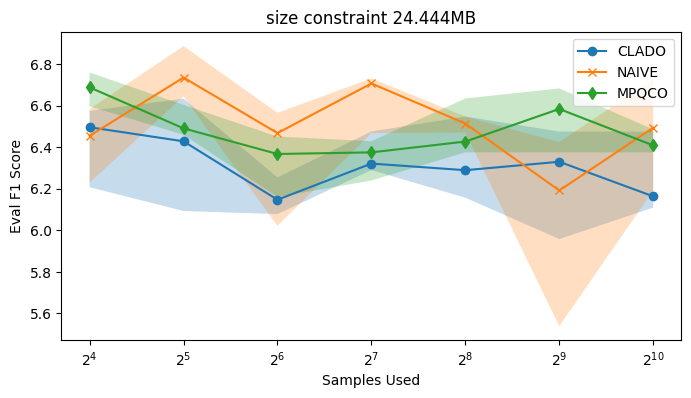

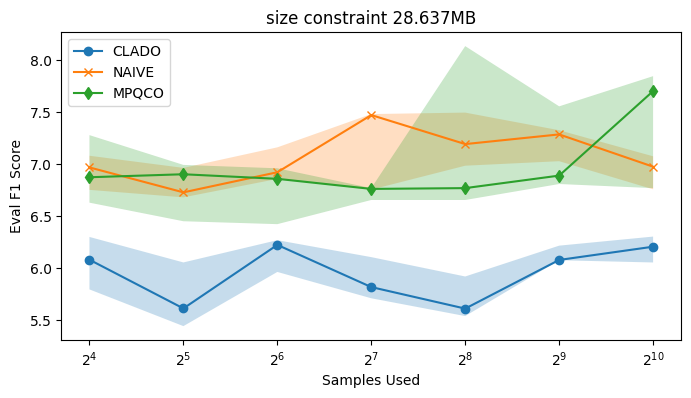

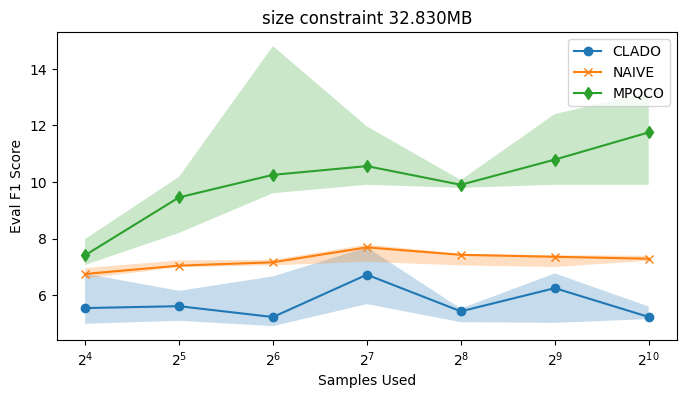

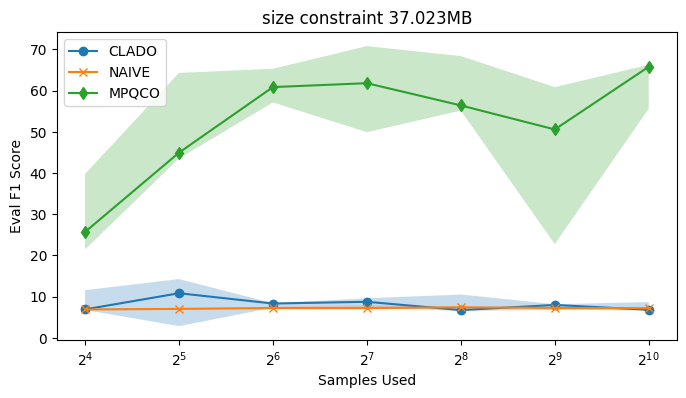

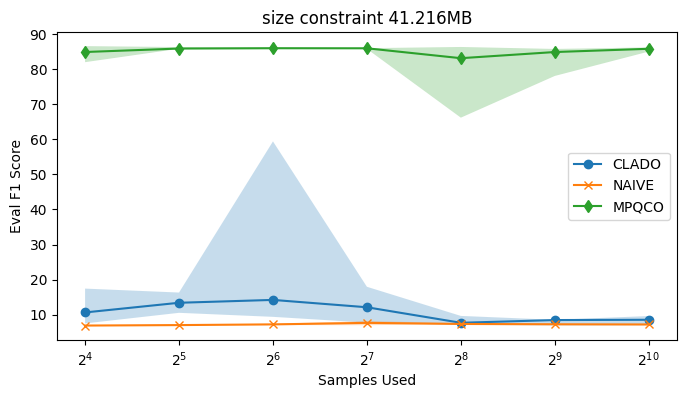

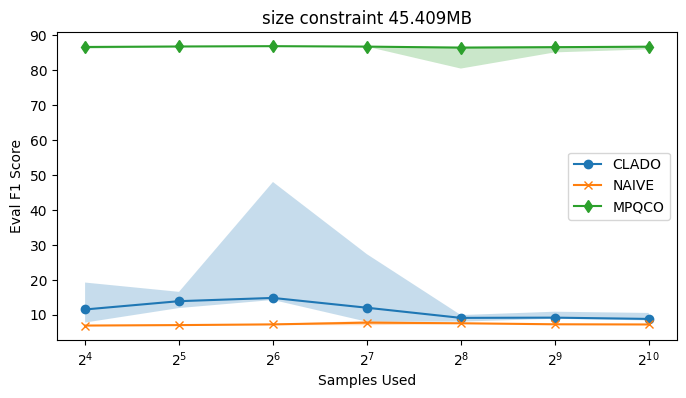

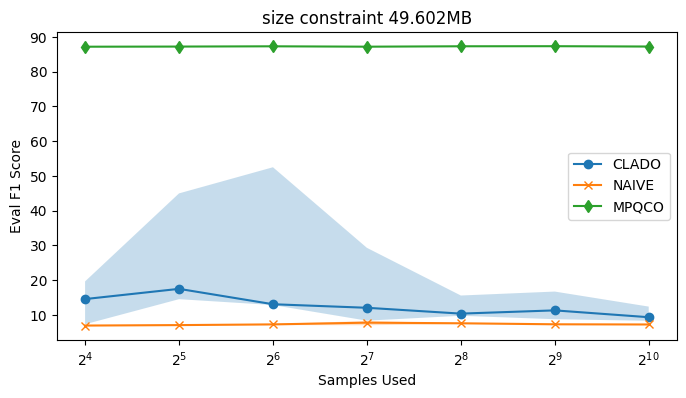

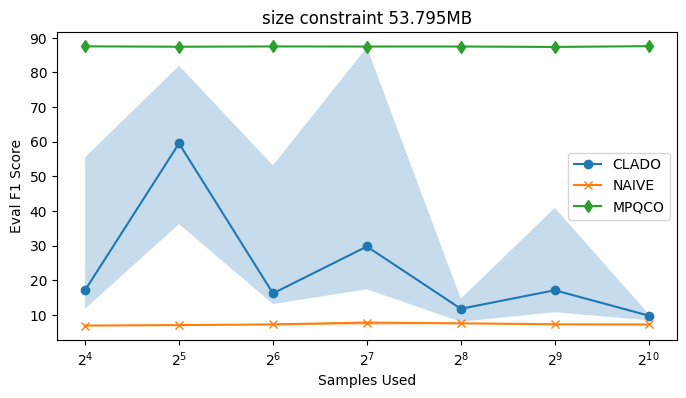

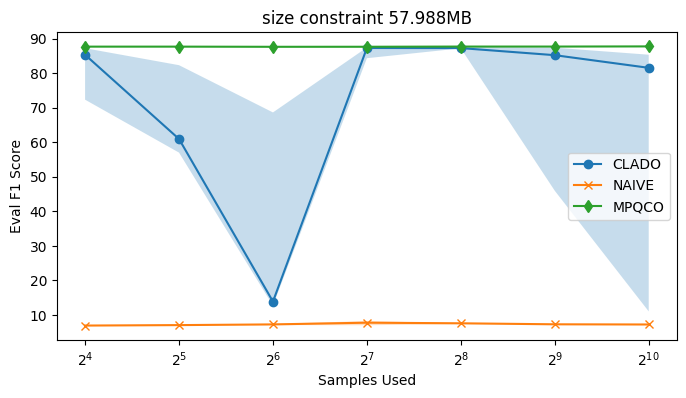

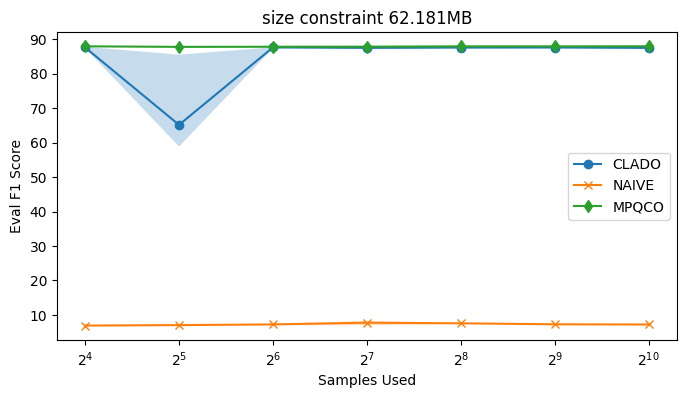

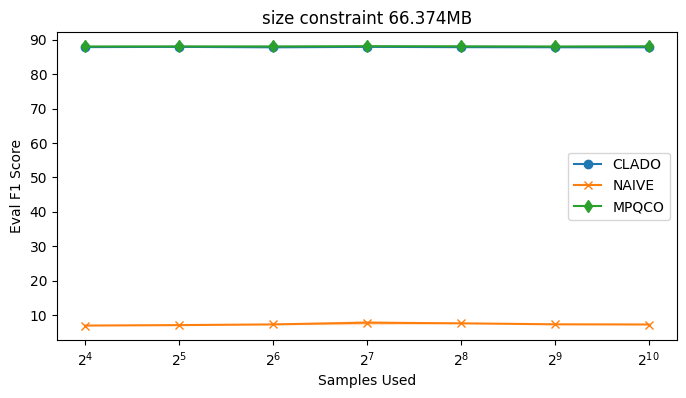

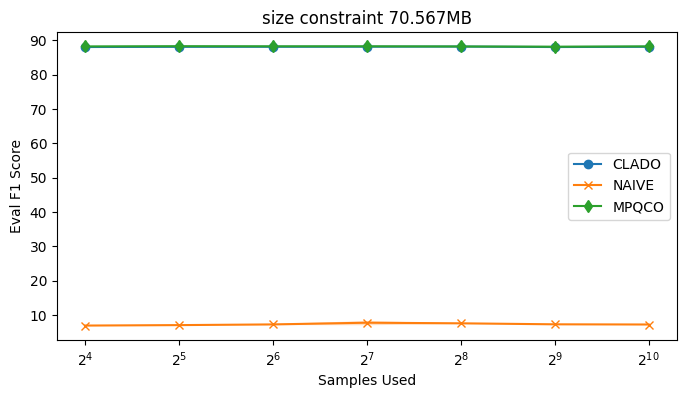

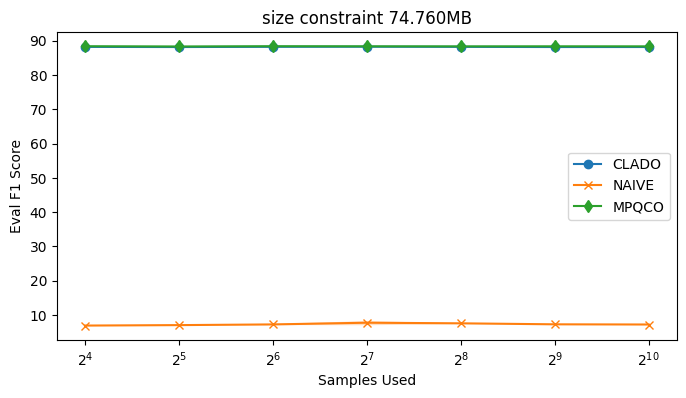

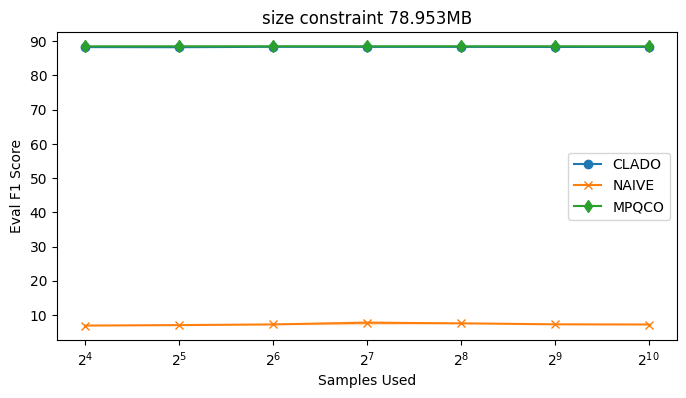

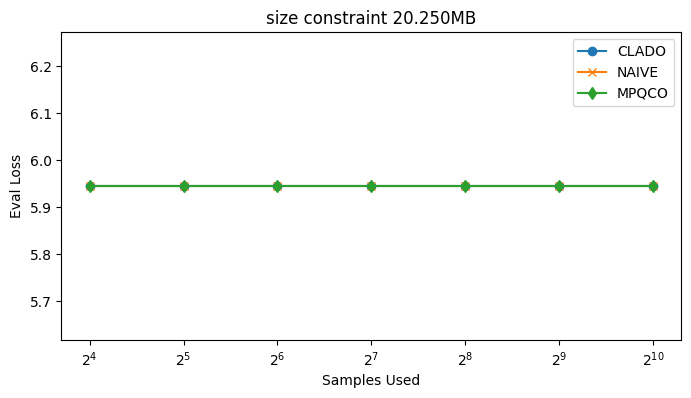

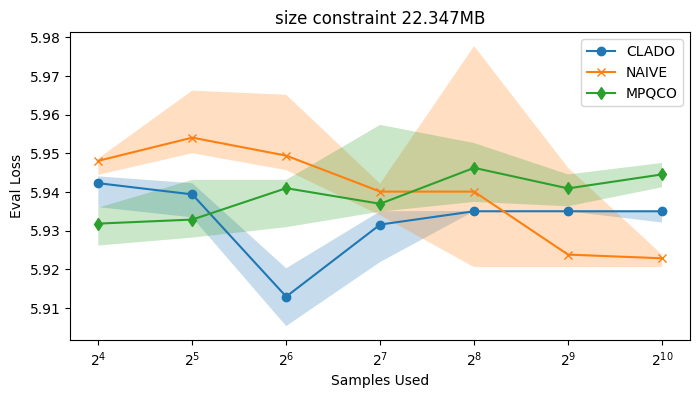

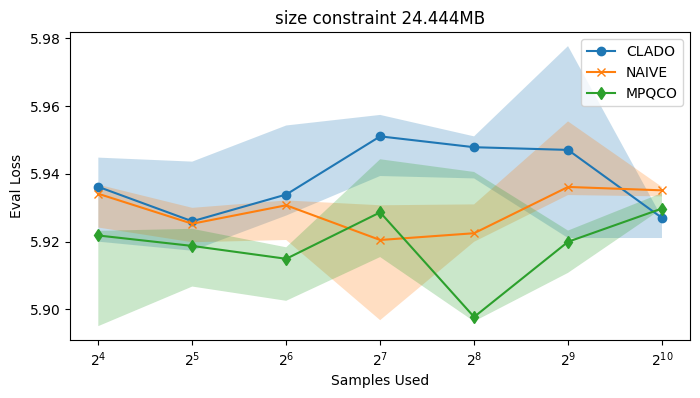

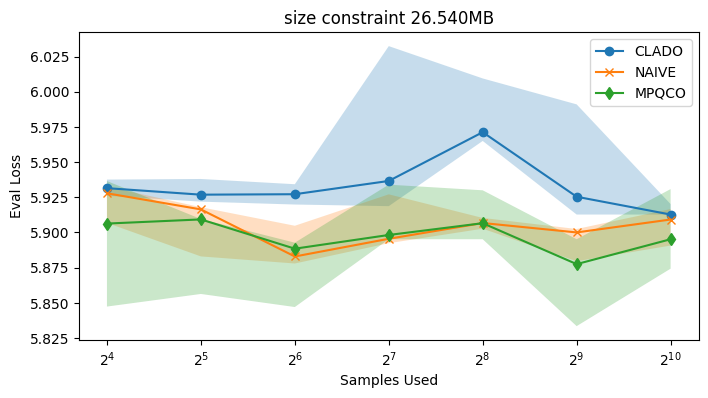

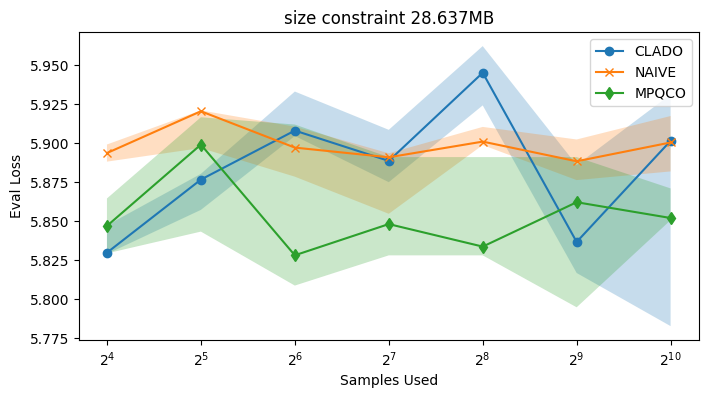

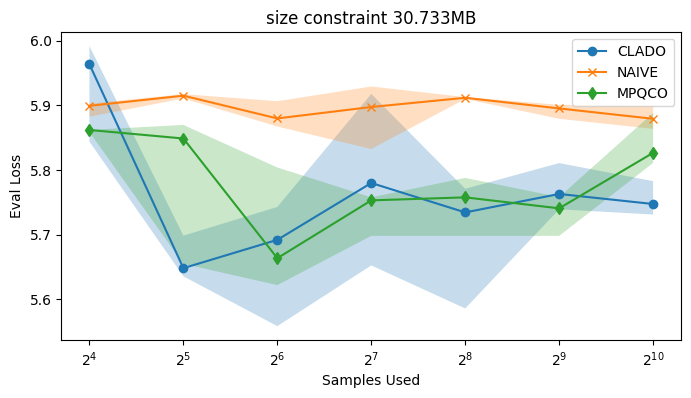

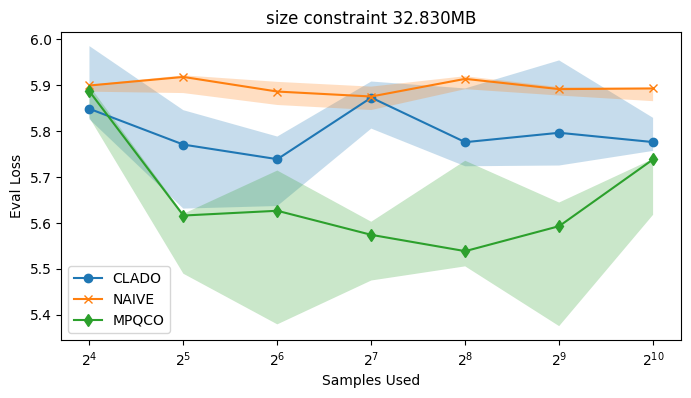

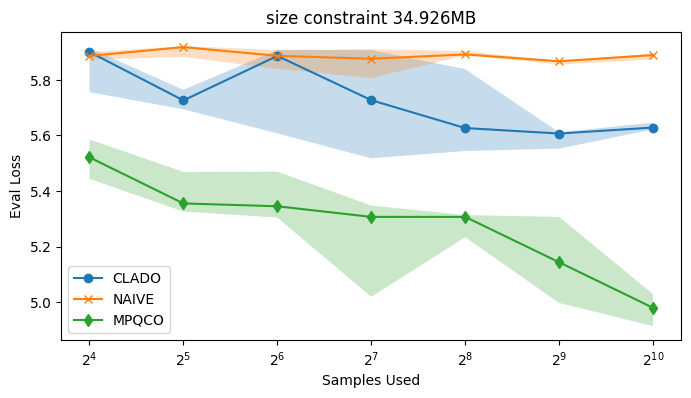

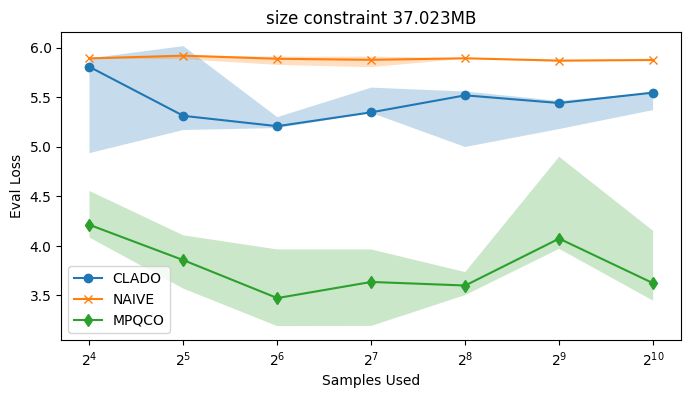

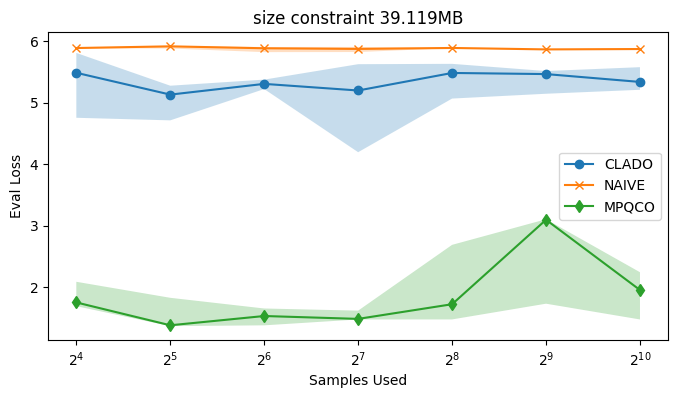

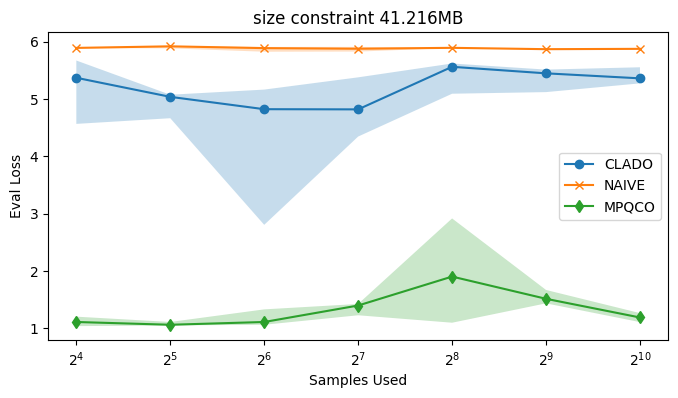

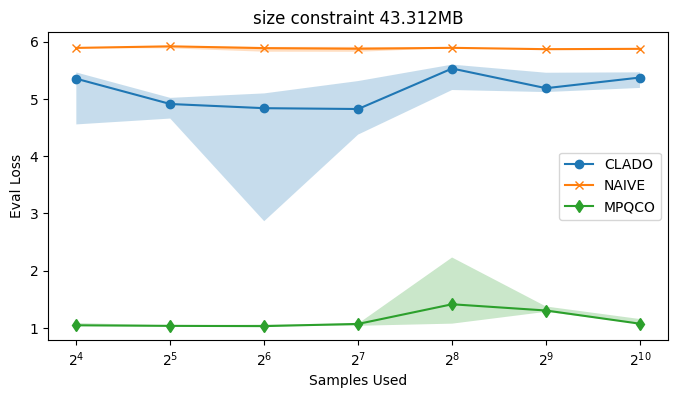

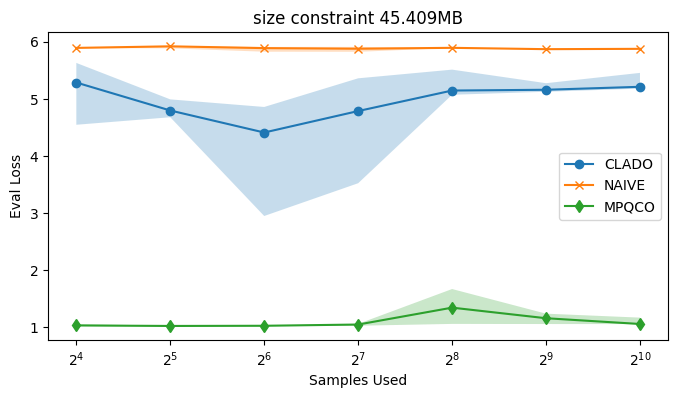

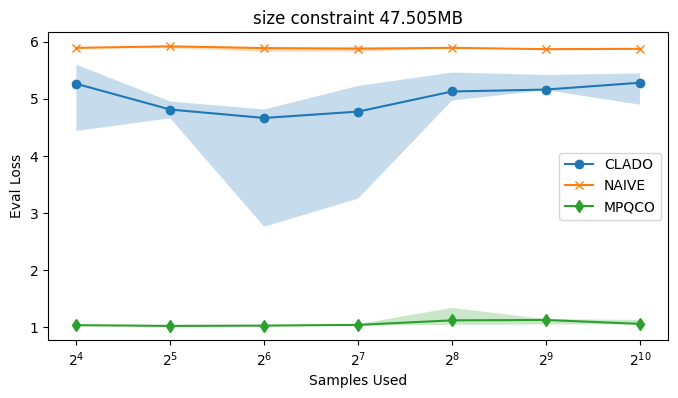

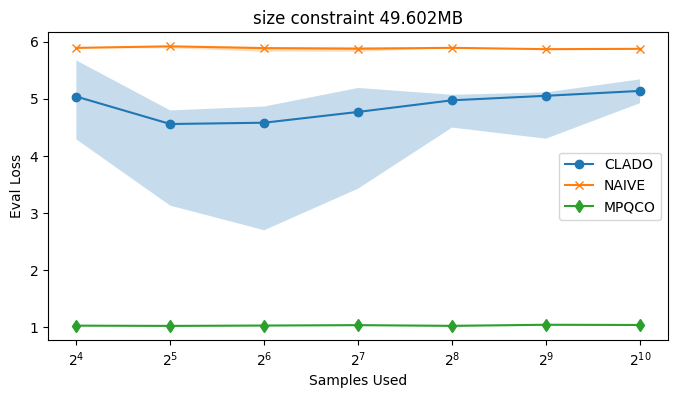

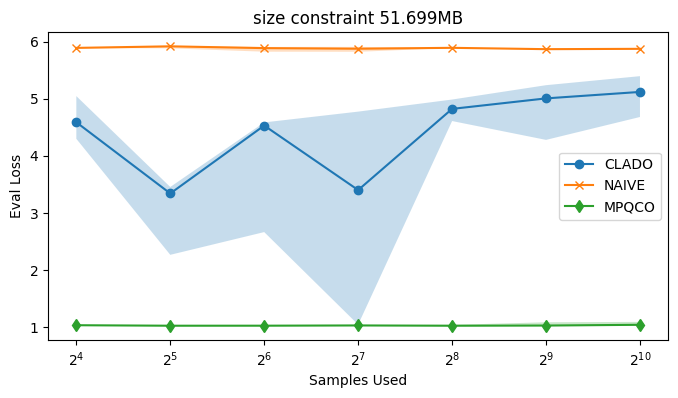

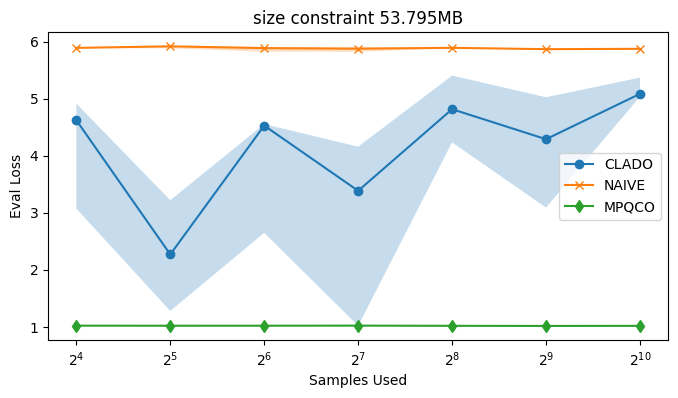

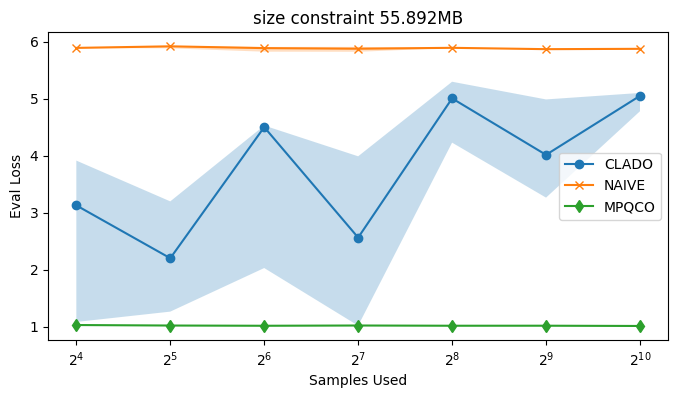

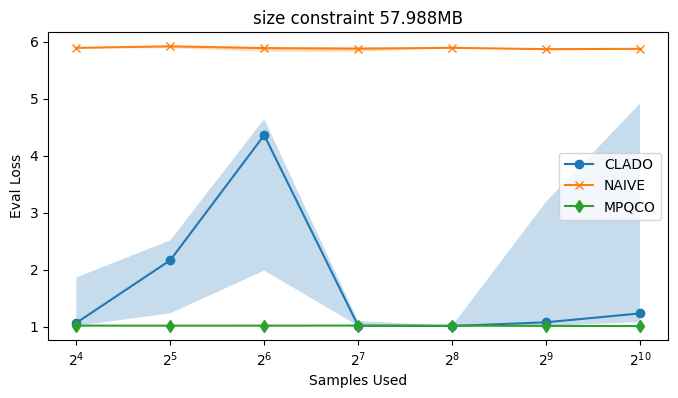

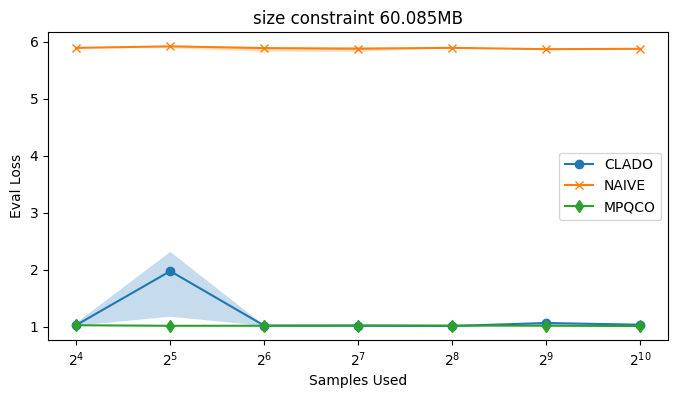

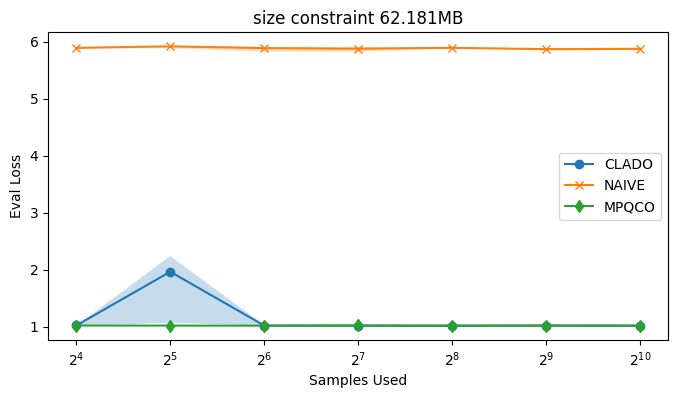

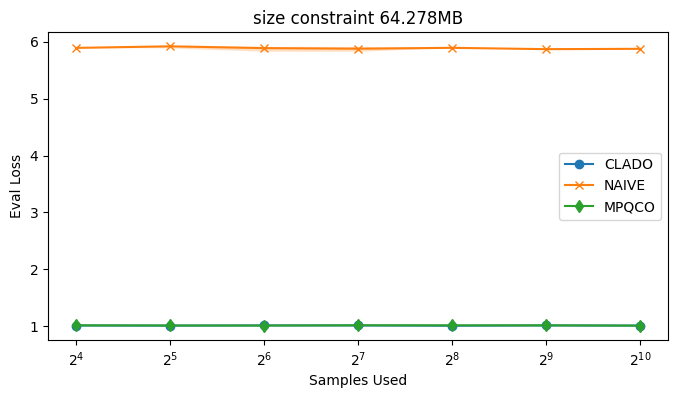

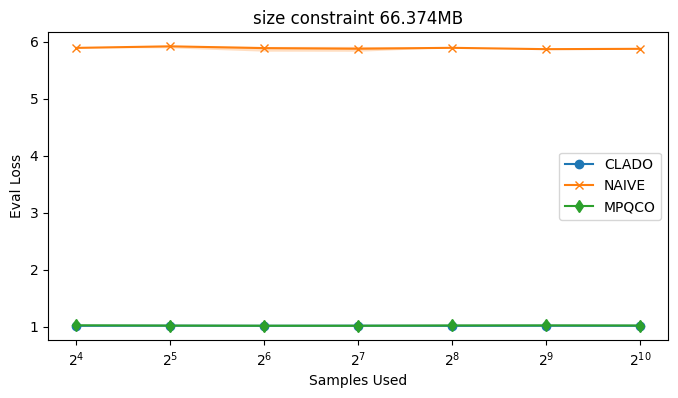

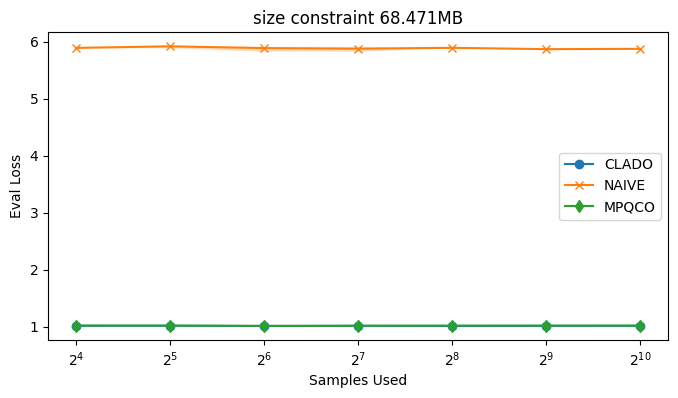

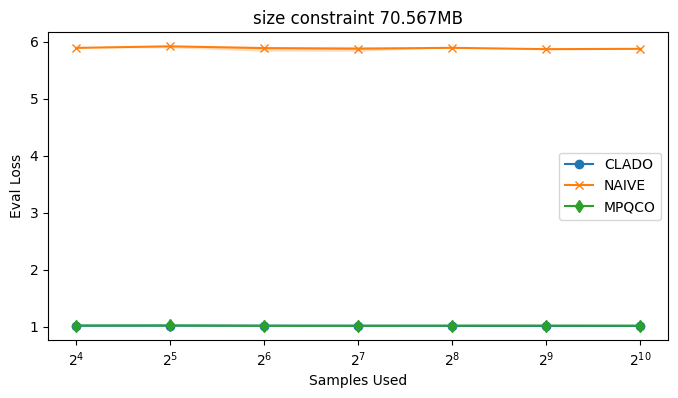

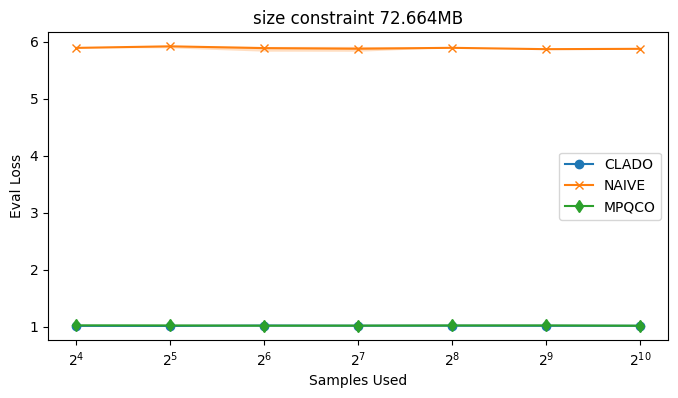

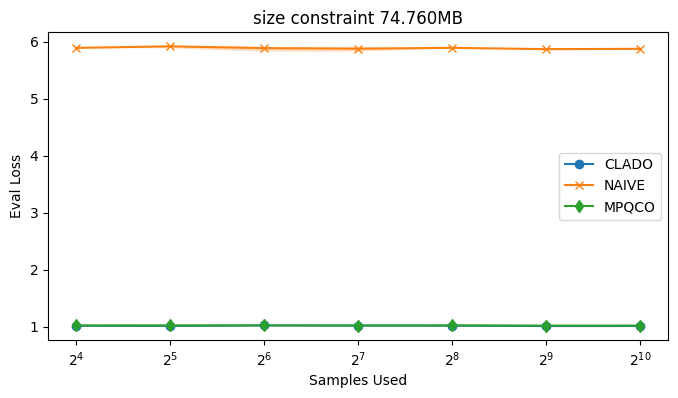

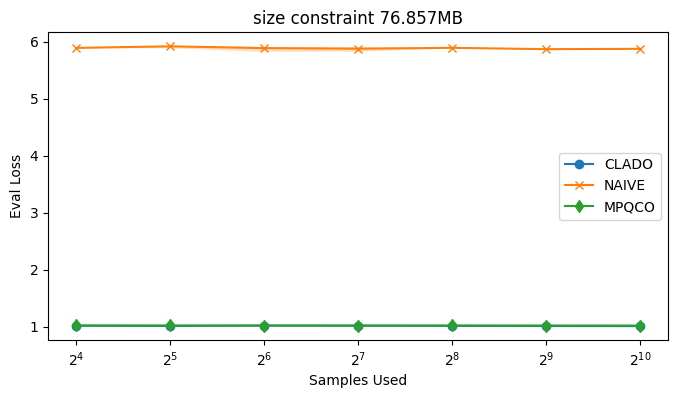

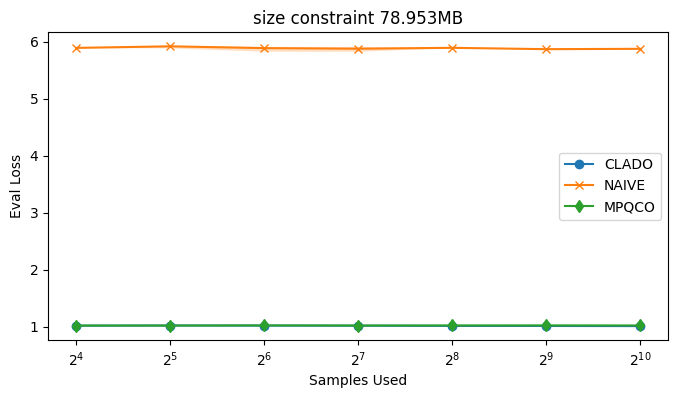

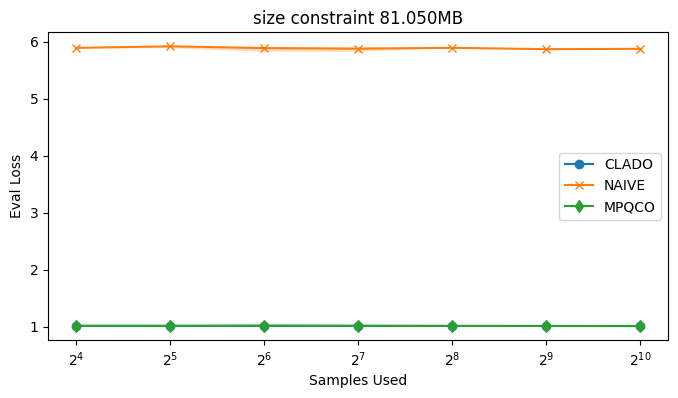

In [15]:

import matplotlib.pyplot as plt
import pickle
import numpy as np

batch_nums = [2, 4, 8, 16, 32, 64, 128]
methods = ["clado", "naive", "mpqco"]
size_bounds = np.linspace(20.2505, 81.05, 30)

n_runs = 5
n_sizes = len(batch_nums)
n_constraints = len(size_bounds)

# n_runs x n_batches x n_constraints 
clado_f1 = [[[0 for _ in range(n_constraints)] for _ in range(n_sizes)] for _ in range(n_runs)]
naive_f1 = [[[0 for _ in range(n_constraints)] for _ in range(n_sizes)] for _ in range(n_runs)]
mpqco_f1 = [[[0 for _ in range(n_constraints)] for _ in range(n_sizes)] for _ in range(n_runs)] 
clado_exact_match = [[[0 for _ in range(n_constraints)] for _ in range(n_sizes)] for _ in range(n_runs)]
naive_exact_match = [[[0 for _ in range(n_constraints)] for _ in range(n_sizes)] for _ in range(n_runs)]
mpqco_exact_match = [[[0 for _ in range(n_constraints)] for _ in range(n_sizes)] for _ in range(n_runs)]
clado_eval_loss = [[[0 for _ in range(n_constraints)] for _ in range(n_sizes)] for _ in range(n_runs)]
naive_eval_loss = [[[0 for _ in range(n_constraints)] for _ in range(n_sizes)] for _ in range(n_runs)]
mpqco_eval_loss = [[[0 for _ in range(n_constraints)] for _ in range(n_sizes)] for _ in range(n_runs)]


for i, batch_num in enumerate(batch_nums):
    for repeat in range(n_runs):
        start_batch = batch_num * repeat
        end_batch = batch_num * repeat + batch_num - 1
        n_samples = batch_num * 8
        file_name = f'./clado_mpqco_results/bert-base/Clado_Naive_MPQCO_res_bert-base/sample_size{n_samples}/clado_naive_mpqco_a16_w8-4-2_calib128_batches_{start_batch}-{end_batch}_bs8.pkl'
        with open(file_name,'rb') as f:
            res = pickle.load(f)  
        for method in methods:
            j = 0  
            for item in eval(f'res["{method}_res"]'):
                eval_f1, eval_exact_match, eval_loss, size, bitops, _ = item
                cmd = f'{method}_f1[repeat][i][j] = {eval_f1}'
                exec(cmd)
                cmd = f'{method}_exact_match[repeat][i][j] = {eval_exact_match}'
                exec(cmd)
                cmd = f'{method}_eval_loss[repeat][i][j] = {eval_loss}'
                exec(cmd)
                j += 1

f1_clado = np.array(clado_f1)
f1_naive = np.array(naive_f1)
f1_mpqco = np.array(mpqco_f1)

xs = 2**np.arange(f1_clado.shape[1]) * 16
for i in range(0, f1_clado.shape[2], 2):
    plt.rcParams['figure.figsize'] = (8,4)

    plt.plot(xs, np.quantile(f1_clado[:,:,i],0.5,axis=0),marker='o',label=f'CLADO')
    plt.fill_between(xs,np.quantile(f1_clado[:,:,i],0.75,axis=0),
                     np.quantile(f1_clado[:,:,i],0.25,axis=0),alpha=0.25)
    
    plt.plot(xs, np.quantile(f1_naive[:,:,i],0.5,axis=0),marker='x',label=f'NAIVE')
    plt.fill_between(xs,np.quantile(f1_naive[:,:,i],0.75,axis=0),
                    np.quantile(f1_naive[:,:,i],0.25,axis=0),alpha=0.25)
    
    plt.plot(xs, np.quantile(f1_mpqco[:,:,i],0.5,axis=0),marker='d',label=f'MPQCO')
    plt.fill_between(xs,np.quantile(f1_mpqco[:,:,i],0.75,axis=0),
                     np.quantile(f1_mpqco[:,:,i],0.25,axis=0),alpha=0.25)
    
    plt.legend()
    plt.ylabel('Eval F1 Score')
    plt.xlabel('Samples Used')
    plt.title(f'size constraint {size_bounds[i]:.3f}MB')
    plt.xscale('log',base=2)
    plt.show()

eval_loss_clado = np.array(clado_eval_loss)
eval_loss_naive = np.array(naive_eval_loss)
eval_loss_mpqco = np.array(mpqco_eval_loss)

for i in range(0, f1_clado.shape[2], 1):
    plt.rcParams['figure.figsize'] = (8,4)
    plt.plot(xs, np.quantile(eval_loss_clado[:,:,i],0.5,axis=0),marker='o',label=f'CLADO')
    plt.fill_between(xs,np.quantile(eval_loss_clado[:,:,i],0.75,axis=0),
                     np.quantile(eval_loss_clado[:,:,i],0.25,axis=0),alpha=0.25)
    
    plt.plot(xs, np.quantile(eval_loss_naive[:,:,i],0.5,axis=0),marker='x',label=f'NAIVE')
    plt.fill_between(xs,np.quantile(eval_loss_naive[:,:,i],0.75,axis=0),
                    np.quantile(eval_loss_naive[:,:,i],0.25,axis=0),alpha=0.25)
    
    plt.plot(xs,np.quantile(eval_loss_mpqco[:,:,i],0.5,axis=0),marker='d',label=f'MPQCO')
    plt.fill_between(xs,np.quantile(eval_loss_mpqco[:,:,i],0.75,axis=0),
                     np.quantile(eval_loss_mpqco[:,:,i],0.25,axis=0),alpha=0.25)
    
    plt.legend()
    plt.ylabel('Eval Loss')
    plt.xlabel('Samples Used')
    plt.title(f'size constraint {size_bounds[i]:.3f}MB')
    plt.xscale('log',base=2)
    plt.show()
